In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import cv2
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib
data_dir = pathlib.Path("/content/drive/MyDrive/BoneFractureDetection/DataSet/train")

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

8871


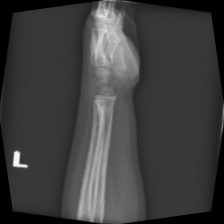

In [ ]:
valid = list(data_dir.glob('fractured/*'))
PIL.Image.open(str(valid[0]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8871 files belonging to 2 classes.
Using 7097 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8871 files belonging to 2 classes.
Using 1774 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['fractured', 'not fractured']


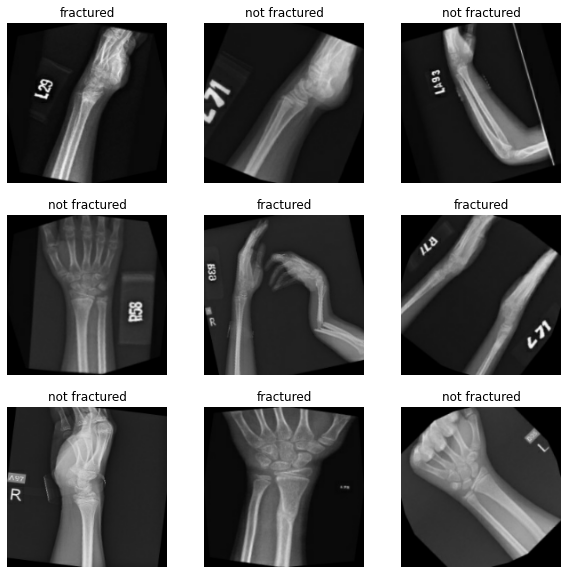

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0 0.78653544


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
222/222 [==============================] - 272s 1s/step - loss: 0.4949 - accuracy: 0.7450 - val_loss: 0.2756 - val_accuracy: 0.8856
Epoch 2/10
222/222 [==============================] - 190s 856ms/step - loss: 0.1521 - accuracy: 0.9418 - val_loss: 0.1019 - val_accuracy: 0.9656
Epoch 3/10
222/222 [==============================] - 185s 836ms/step - loss: 0.0432 - accuracy: 0.9848 - val_loss: 0.1452 - val_accuracy: 0.9481
Epoch 4/10
222/222 [==============================] - 187s 841ms/step - loss: 0.0318 - accuracy: 0.9913 - val_loss: 0.0674 - val_accuracy: 0.9769
Epoch 5/10
222/222 [==============================] - 184s 831ms/step - loss: 0.0061 - accuracy: 0.9987 - val_loss: 0.0606 - val_accuracy: 0.9865
Epoch 6/10
222/222 [==============================] - 184s 828ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0593 - val_accuracy: 0.9865
Epoch 7/10
222/222 [==============================] - 198s 890ms/step - loss: 1.5051e-04 - accuracy: 1.0000 - val_loss: 0.0621 

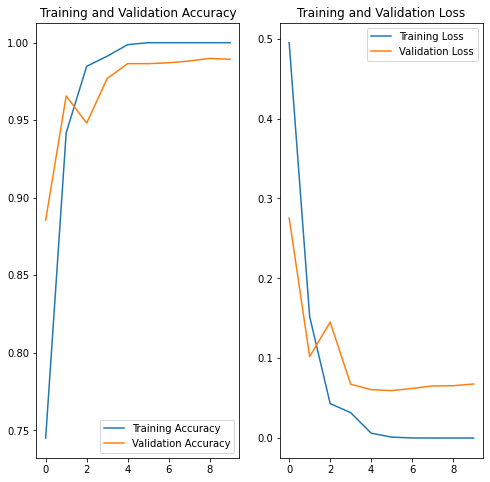

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

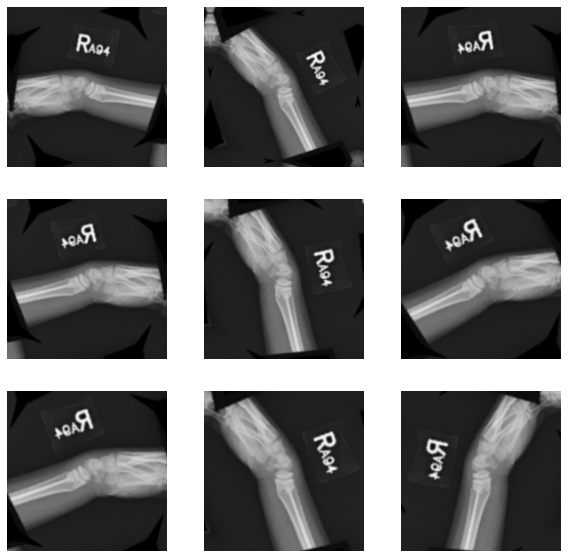

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


222/222 [==============================] - 215s 951ms/step - loss: 0.6193 - accuracy: 0.6566 - val_loss: 0.8236 - val_accuracy: 0.5693
Epoch 2/15
222/222 [==============================] - 206s 929ms/step - loss: 0.4568 - accuracy: 0.7802 - val_loss: 0.9632 - val_accuracy: 0.6201
Epoch 3/15
222/222 [==============================] - 213s 958ms/step - loss: 0.2955 - accuracy: 0.8692 - val_loss: 1.1135 - val_accuracy: 0.6240
Epoch 4/15
222/222 [==============================] - 221s 995ms/step - loss: 0.1866 - accuracy: 0.9249 - val_loss: 1.5083 - val_accuracy: 0.5851
Epoch 5/15
222/222 [==============================] - 225s 1s/step - loss: 0.1348 - accuracy: 0.9487 - val_loss: 1.4240 - val_accuracy: 0.6015
Epoch 6/15
222/222 [==============================] - 217s 979ms/step - loss: 0.0909 - accuracy: 0.9679 - val_loss: 1.3358 - val_accuracy: 0.6595
Epoch 7/15
222/222 [==============================] - 222s 1s/step - loss: 0.0790 - accuracy: 0.9735 - val_loss: 1.7457 - val_accuracy: 0.

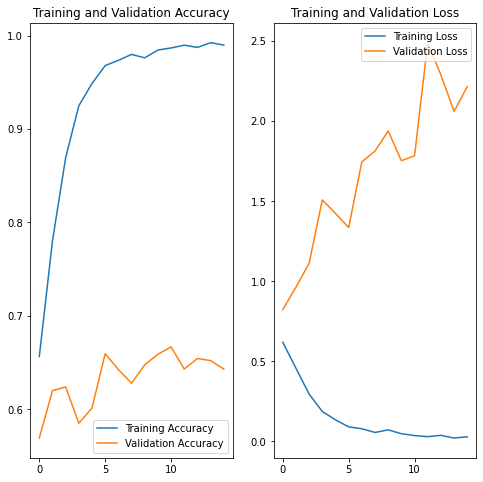

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_image = "/content/drive/MyDrive/Test/imgtr246.png"

img = tf.keras.utils.load_img(
    test_image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 185ms/step
This image most likely belongs to fractured with a 98.18 percent confidence.


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('/content/drive/MyDrive/model.tflite', 'wb') as f:
  f.write(tflite_model)
